# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

In [93]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import sys
# sys.path.append('..')
sys.path.insert(0, "/g/g13/jones289/workspace/hd-cuda-master")
# print(sys.path)
import hdpy
import hdpy.ecfp
# from hdpy.analysis import load_pkl
from hdpy.metrics import compute_enrichment_factor
from pathlib import Path


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


# SEED=125
SEED=5
# SEED=2

data_p = Path(f"/p/vast1/jones289/hd_results/{SEED}")

In [94]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [95]:
model_dict = {
    "molehd-bpe": ("MoleHD-BPE", rocket_color_pal[4]),
    "hdbind-rp-molformer": ("HDBind+MolFormer", green_color_pal[4]),
    "hdbind-ecfp-1024-1-100": ("HDBind+ECFP-100", green_color_pal[6]),
    "hdbind-ecfp-1024-1-1k": ("HDBind+ECFP-1k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1": ("HDBind+ECFP-10k", green_color_pal[6]),
    "hdbind-ecfp-1024-1-100k": ("HDBind+ECFP-100k", green_color_pal[9]),
#     "mlp-1024-1": ("MLP", blue_color_pal[7]),
    "Vina": ("Vina", "salmon"),
}

# LIT-PCBA Results

export CONDA_ROOT=/usr/workspace/jones289/anaconda3-power #installed using the LC installer script
export PATH=$CONDA_ROOT/bin:$PATH
export CONDA_EXE=$CONDA_ROOT/bin/conda
ml load gcc/11
export PYTHONPATH=$PWD:$PYTHONPATH
source activate /usr/workspace/jones289/anaconda3-power/envs/opence-1.8.0

In [112]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score


def compute_metrics(y_pred, y_score, y_true, p):
#     import pdb
#     pdb.set_trace()


    if y_score.squeeze().ndim == 2:
        enrich = float(compute_enrichment_factor(scores=y_score[:, 1], labels=y_true, n_percent=p))
        roc = roc_auc_score(y_score=y_score[:, 1], y_true=y_true)
    else:
        enrich = float(compute_enrichment_factor(scores=y_score, labels=y_true, n_percent=p))
        roc = roc_auc_score(y_score=y_score, y_true=y_true)

    
    
    return {"precision": precision_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "recall": recall_score(y_pred=y_pred, y_true=y_true),
           "f1": f1_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "enrich": enrich,            
           "roc": roc
           }


def aggregate_results(dataset, split):
    
    
    
    if split == "random":
        raise NotImplementedError # rename the files with "-random" to be consistent
        
    
    model_metric_dict = {"model": [], "enrich": [], "p":[], "train_time":[], "test_time": [], "target": [],
                        "seed": [], "recall": [], "precision": [], "f1": [], 
                        }

    
    
    df_list = []
    for model_name, model_tup in tqdm(model_dict.items(), total=len(model_dict), position=0):
                        

        data_path_list = list(data_p.glob(f"{model_name}.{dataset}-*-{split}*.pkl"))
        print(f"{model_name}-{dataset}: {len(model_tup)}\t {len(data_path_list)}")

        

        for path in tqdm(data_path_list, total=len(data_path_list), position=1):
            target = path.name.split(".")[1]

            print(target, path, model_name)

            
#             model_data_dict = pd.read_pickle(path)

            try:
                model_data_dict = torch.load(path)
            except RuntimeError as e:
                print(e)
                print("fixing pickle and saving as pytorch object")
                with open(path, "rb") as handle:
                    model_data_dict = pickle.load(handle)
                    torch.save(model_data_dict, path)
            

            
            
            for seed in range(len(model_data_dict['trials'])):
                scores_smiles_dict = {"smiles": None,
                                      "model": None,
                                      "target": None, 
                                      "score": None,
                                      "seed": None, 
                                      "label": None}
    
                
                trial_dict = model_data_dict['trials'][seed]

                y_test = model_data_dict["y_test"]



                scores_smiles_dict["smiles"] = model_data_dict["smiles_test"]
                scores_smiles_dict["target"] = np.array([target]*len(y_test)).flatten()
                scores_smiles_dict["score"] = model_data_dict['trials'][seed]["eta"].flatten()
                scores_smiles_dict["label"] = model_data_dict['trials'][seed]["y_true"].flatten()
                scores_smiles_dict["model"] = np.array([model_name]*len(y_test)).flatten()
                scores_smiles_dict["seed"] = np.array([seed]*len(y_test)).flatten()
                
                df_list.append(pd.DataFrame(scores_smiles_dict))
#                 import pdb
#                 pdb.set_trace()
                actives_database = sum(y_test)
                database_size = y_test.shape[0]



                hdc_conf_scores = trial_dict["eta"]
                for p in [.01, .1]:

                    try:

                        metrics = compute_metrics(y_pred=trial_dict["y_pred"], 
                                                  y_score=hdc_conf_scores, 
                                                  y_true=model_data_dict["y_test"],
                                                 p=p)

                        model_metric_dict["target"].append(target)
                        model_metric_dict["test_time"].append(trial_dict["test_time"])
                        model_metric_dict["enrich"].append(metrics["enrich"])
                        model_metric_dict["p"].append(p)
                        model_metric_dict["seed"].append(seed)
                        model_metric_dict["precision"].append(metrics["precision"])
                        model_metric_dict["recall"].append(metrics["recall"])
                        model_metric_dict["f1"].append(metrics["f1"])
                        model_metric_dict["model"].append(model_name)
                    except Exception as e:
                        print(e)


    model_metric_df = pd.DataFrame({key: value for key, value in model_metric_dict.items() if key not in ["train_time", "test_time", "precision", "recall", "f1"]})
#     return model_metric_df, pd.DataFrame(scores_smiles_dict)
#     return model_metric_df, None
    return model_metric_df, df_list
        


In [113]:
litpcba_df, smiles_scores_df = aggregate_results(dataset="lit-pcba", split="ave")

  0%|          | 0/7 [00:00<?, ?it/s]

molehd-bpe-lit-pcba: 2	 7



  0%|          | 0/7 [00:00<?, ?it/s]

lit-pcba-ESR1_ago-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ago-ave.5.pkl molehd-bpe



 14%|█▍        | 1/7 [00:00<00:01,  3.32it/s]

lit-pcba-ESR1_ant-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ant-ave.5.pkl molehd-bpe



 29%|██▊       | 2/7 [00:00<00:01,  3.42it/s]

lit-pcba-MAPK1-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MAPK1-ave.5.pkl molehd-bpe



 43%|████▎     | 3/7 [00:03<00:06,  1.61s/it]

lit-pcba-MTORC1-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MTORC1-ave.5.pkl molehd-bpe



 57%|█████▋    | 4/7 [00:05<00:04,  1.61s/it]

lit-pcba-PKM2-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PKM2-ave.5.pkl molehd-bpe



 71%|███████▏  | 5/7 [00:19<00:12,  6.07s/it]

lit-pcba-PPARG-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PPARG-ave.5.pkl molehd-bpe



 86%|████████▌ | 6/7 [00:19<00:04,  4.11s/it]

lit-pcba-TP53-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-TP53-ave.5.pkl molehd-bpe



 14%|█▍        | 1/7 [00:19<01:59, 19.93s/it]

hdbind-rp-molformer-lit-pcba: 2	 0



0it [00:00, ?it/s]


hdbind-ecfp-1024-1-100-lit-pcba: 2	 0



0it [00:00, ?it/s]


hdbind-ecfp-1024-1-1k-lit-pcba: 2	 0



0it [00:00, ?it/s]


hdbind-rp-ecfp-1024-1-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-ecfp-1024-1



  7%|▋         | 1/15 [00:18<04:22, 18.75s/it]

lit-pcba-ALDH1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-ecfp-1024-1



 13%|█▎        | 2/15 [00:24<02:25, 11.17s/it]

lit-pcba-ESR1_ago-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-ecfp-1024-1



 20%|██        | 3/15 [00:24<01:14,  6.21s/it]

lit-pcba-ESR1_ant-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-ecfp-1024-1



 27%|██▋       | 4/15 [00:25<00:42,  3.87s/it]

lit-pcba-FEN1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-FEN1-ave.5.pkl hdbind-rp-ecfp-1024-1



 33%|███▎      | 5/15 [00:46<01:41, 10.12s/it]

lit-pcba-GBA-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-GBA-ave.5.pkl hdbind-rp-ecfp-1024-1



 40%|████      | 6/15 [01:03<01:52, 12.55s/it]

lit-pcba-IDH1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-IDH1-ave.5.pkl hdbind-rp-ecfp-1024-1



 47%|████▋     | 7/15 [01:25<02:04, 15.52s/it]

lit-pcba-KAT2A-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-ecfp-1024-1



 53%|█████▎    | 8/15 [01:46<02:00, 17.19s/it]

lit-pcba-MAPK1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-ecfp-1024-1



 60%|██████    | 9/15 [01:49<01:16, 12.79s/it]

lit-pcba-MTORC1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-ecfp-1024-1



 67%|██████▋   | 10/15 [01:50<00:46,  9.33s/it]

lit-pcba-OPRK1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-ecfp-1024-1



 73%|███████▎  | 11/15 [02:06<00:45, 11.29s/it]

lit-pcba-PKM2-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PKM2-ave.5.pkl hdbind-rp-ecfp-1024-1



 80%|████████  | 12/15 [02:20<00:36, 12.09s/it]

lit-pcba-PPARG-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PPARG-ave.5.pkl hdbind-rp-ecfp-1024-1



 87%|████████▋ | 13/15 [02:20<00:17,  8.52s/it]

lit-pcba-TP53-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-TP53-ave.5.pkl hdbind-rp-ecfp-1024-1



 93%|█████████▎| 14/15 [02:20<00:06,  6.02s/it]

lit-pcba-VDR-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-VDR-ave.5.pkl hdbind-rp-ecfp-1024-1



 71%|███████▏  | 5/7 [02:55<01:12, 36.16s/it]

hdbind-ecfp-1024-1-100k-lit-pcba: 2	 0



0it [00:00, ?it/s]


Vina-lit-pcba: 2	 0



0it [00:00, ?it/s]
100%|██████████| 7/7 [02:55<00:00, 25.13s/it]


In [116]:
lit_pcba_scores_df = pd.concat(smiles_scores_df)

# VINA result

In [117]:
from pathlib import Path

def load_lit_pcba_vina(nrows=None):
    root_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/")

    path_list = [path for path in root_p.glob("*-actives.csv")]
#     import pdb
#     pdb.set_trace()
#     path_list = [path_list[0]]

    df_list = []

    for idx, path in tqdm(enumerate(path_list), total=len(path_list)):
        print(idx, path)
        
#         '''
        target = path.name.split(".")[0].split("-")[0]
        print(target, idx+1, path)
        
        

        merged_df = None
        merged_df_path = Path(f"./lit_pcba_docking_analysis/{target}.csv")
        
        if not merged_df_path.exists():
            # can use the set of smiles in each result file
            
            # todo (10/18/23): is this valid?
            # (12/12/23): ????
            result_pkl = Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/124/lit_pcba.{target}.ecfp.atomwise.0.pkl")        


            target_train_smiles_list = []
            target_test_smiles_list = []

            with open(result_pkl, "rb") as handle:

                data = pickle.load(handle)

                target_train_smiles_list = data["smiles_train"]
                target_test_smiles_list = data["smiles_test"]

                print(f"total of {len(target_train_smiles_list)} in training set, total of {len(target_test_smiles_list)} in testing set.")

            df_cols = ['file', ' scores/1', ' ligName']
            active_df = pd.read_csv(root_p / Path(f"{target}-actives.csv.clean"), sep=",", usecols=df_cols, nrows=nrows)
            active_df['y_true'] = [1] * len(active_df)



            inactive_df = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), sep=",", usecols=df_cols, nrows=nrows)
            inactive_df['y_true'] = [0] * len(inactive_df)

            target_df = pd.concat([active_df, inactive_df])
            # this will search over all of the docking results for each target, across each of the multiple protein models

            active_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/actives.smi", delim_whitespace=True, header=None)
            inactive_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/inactives.smi", delim_whitespace=True, header=None)
            target_smiles_df = pd.concat([active_smiles_df, inactive_smiles_df])



            top_pose_target_df = target_df.groupby([' ligName'], as_index=False)[[' ligName', ' scores/1', 'y_true']].min()


        
            merged_df_path.parent.mkdir(exist_ok=True, parents=True)
            merged_df = pd.merge(top_pose_target_df, target_smiles_df, left_on=" ligName", right_on=1)
            merged_df = merged_df[merged_df.apply(lambda x: x[0] in target_test_smiles_list, axis=1)]
            merged_df['target'] = [target] * len(merged_df)
            merged_df.to_csv(merged_df_path, index=False)
        else:
            merged_df = pd.read_csv(merged_df_path)
            
            if 'target' not in merged_df.columns:
                merged_df['target'] = [target] * len(merged_df)
                merged_df.to_csv(merged_df_path, index=False)



        df_list.append(merged_df)

    df = pd.concat(df_list)
#     import pdb
#     pdb.set_trace()
    df['vina'] = df[' scores/1']
    return df

In [118]:
lit_pcba_vina_df = load_lit_pcba_vina()
lit_pcba_vina_df

  0%|          | 0/15 [00:00<?, ?it/s]

0 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PKM2-actives.csv
PKM2 1 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PKM2-actives.csv


  7%|▋         | 1/15 [00:00<00:03,  4.53it/s]

1 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/GBA-actives.csv
GBA 2 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/GBA-actives.csv


 13%|█▎        | 2/15 [00:00<00:02,  4.53it/s]

2 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ago-actives.csv
ESR1_ago 3 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ago-actives.csv
3 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MAPK1-actives.csv
MAPK1 4 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MAPK1-actives.csv
4 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/VDR-actives.csv
VDR 5 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/VDR-actives.csv


 33%|███▎      | 5/15 [00:00<00:01,  6.61it/s]

5 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/KAT2A-actives.csv
KAT2A 6 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/KAT2A-actives.csv


 53%|█████▎    | 8/15 [00:01<00:00,  8.20it/s]

6 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ALDH1-actives.csv
ALDH1 7 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ALDH1-actives.csv
7 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/TP53-actives.csv
TP53 8 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/TP53-actives.csv
8 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PPARG-actives.csv
PPARG 9 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PPARG-actives.csv
9 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ADRB2-actives.csv
ADRB2 10 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ADRB2-actives.csv


 80%|████████  | 12/15 [00:01<00:00, 10.24it/s]

10 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MTORC1-actives.csv
MTORC1 11 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MTORC1-actives.csv
11 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/OPRK1-actives.csv
OPRK1 12 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/OPRK1-actives.csv
12 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/IDH1-actives.csv
IDH1 13 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/IDH1-actives.csv


100%|██████████| 15/15 [00:01<00:00,  8.03it/s]

13 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ant-actives.csv
ESR1_ant 14 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ant-actives.csv
14 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/FEN1-actives.csv
FEN1 15 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/FEN1-actives.csv


,ligName,scores/1,y_true,0,1,target,vina
0,842131,-10.9,0,C(Nc1nc(nc2ccccc12)N3CCCCC3)c4occc4,842131,PKM2,-10.9
1,842137,-13.6,0,Cc1ccc2nc(N3CC[NH+](Cc4nnnn4Cc5ccccc5)CC3)c(cc...,842137,PKM2,-13.6
2,842144,-11.0,0,Cc1ccc(C)c(NC(=O)CSc2nnc(CSc3nc(C)cc(C)n3)n2Cc...,842144,PKM2,-11.0
3,842162,-11.3,0,COc1cccc(c1)C(=O)Nc2ccc(cc2)S(=O)(=O)NCc3occc3,842162,PKM2,-11.3
4,842164,-8.8,0,O=C(Cn1nnc(n1)c2cccs2)OC3CCCCC3,842164,PKM2,-8.8
...,...,...,...,...,...,...,...
90550,124899201,-5.2,0,[O-][N+](=O)c1cccc(\C=C\c2ccccc2)c1,124899201,FEN1,-5.2
90551,124899232,-5.1,0,CN(CCCCCC[NH3+])c1nccc(n1)N2CC[NH+](C)CC2,124899232,FEN1,-5.1
90552,124899250,-5.3,0,ONC(=O)Cc1ccc(OCC2CCCCC2)cc1,124899250,FEN1,-5.3
90553,124899255,-4.9,0,CC(C)CCOc1ccc(CC(=O)NO)cc1,124899255,FEN1,-4.9


In [121]:
merged_df = pd.merge(lit_pcba_scores_df, lit_pcba_vina_df, left_on="smiles", right_on="0")

In [122]:
merged_df

,smiles,model,target_x,score,seed,label,ligName,scores/1,y_true,0,1,target_y,vina
0,CCCCCCCCC(=O)NCc1ccc(O)c(OC)c1,molehd-bpe,lit-pcba-ESR1_ago-ave,0,0,0,11111961,-7.8,0,CCCCCCCCC(=O)NCc1ccc(O)c(OC)c1,11111961,MAPK1,-7.8
1,CCCCCCCCC(=O)NCc1ccc(O)c(OC)c1,molehd-bpe,lit-pcba-ESR1_ago-ave,0,0,0,26747691,-7.7,0,CCCCCCCCC(=O)NCc1ccc(O)c(OC)c1,26747691,MAPK1,-7.7
2,CCCCCCCCC(=O)NCc1ccc(O)c(OC)c1,molehd-bpe,lit-pcba-ESR1_ago-ave,0,0,0,56463512,-8.1,0,CCCCCCCCC(=O)NCc1ccc(O)c(OC)c1,56463512,VDR,-8.1
3,CCCCCCCCC(=O)NCc1ccc(O)c(OC)c1,molehd-bpe,lit-pcba-ESR1_ago-ave,0,0,0,104171264,-8.0,0,CCCCCCCCC(=O)NCc1ccc(O)c(OC)c1,104171264,VDR,-8.0
4,CCCCCCCCC(=O)NCc1ccc(O)c(OC)c1,molehd-bpe,lit-pcba-ESR1_ago-ave,0,0,0,56463512,-7.1,0,CCCCCCCCC(=O)NCc1ccc(O)c(OC)c1,56463512,KAT2A,-7.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11571745,Cc1ccc(cc1)N2C3=C(C(C4=C2CC(C)(C)CC4=O)c5cn(C)...,hdbind-rp-ecfp-1024-1,lit-pcba-VDR-ave,0,5,1,17411552,-8.3,0,Cc1ccc(cc1)N2C3=C(C(C4=C2CC(C)(C)CC4=O)c5cn(C)...,17411552,IDH1,-8.3
11571746,Cc1ccc(cc1)N2C3=C(C(C4=C2CC(C)(C)CC4=O)c5cn(C)...,hdbind-rp-ecfp-1024-1,lit-pcba-VDR-ave,0,6,1,17411552,-8.3,0,Cc1ccc(cc1)N2C3=C(C(C4=C2CC(C)(C)CC4=O)c5cn(C)...,17411552,IDH1,-8.3
11571747,Cc1ccc(cc1)N2C3=C(C(C4=C2CC(C)(C)CC4=O)c5cn(C)...,hdbind-rp-ecfp-1024-1,lit-pcba-VDR-ave,0,7,1,17411552,-8.3,0,Cc1ccc(cc1)N2C3=C(C(C4=C2CC(C)(C)CC4=O)c5cn(C)...,17411552,IDH1,-8.3
11571748,Cc1ccc(cc1)N2C3=C(C(C4=C2CC(C)(C)CC4=O)c5cn(C)...,hdbind-rp-ecfp-1024-1,lit-pcba-VDR-ave,0,8,1,17411552,-8.3,0,Cc1ccc(cc1)N2C3=C(C(C4=C2CC(C)(C)CC4=O)c5cn(C)...,17411552,IDH1,-8.3


In [70]:
# def load_dude_vina(nrows=None):
#     vina_root_p = Path("/p/lustre1/jones289/DUDE-38/")
#     vina_path_list = [path for path in vina_root_p.glob("*-active-summary.txt")]

#     df_list = []


#     # root_dude_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dude/dude_smiles/")
#     root_dude_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dude_smiles")
#     for idx, path in enumerate(tqdm(vina_path_list)):
#     #     print(idx, path)
#         target = path.name.split(".")[0].split("-")[0]
# #         print(target, idx+1, path)

#         # for some reason don't have inactive data for abl1
#         if target in ["abl1", "fgfr1"]:
#             tqdm.write(f"{target} not found. skipping.")
#             continue

# #         if target in dude_target_names:
#         else:

#             active_df = pd.read_csv(f"/p/lustre1/jones289/DUDE-38/{target}-active-summary.txt", header=None, delim_whitespace=True)
#             active_df['y_true'] = [1] * len(active_df)

#             decoy_df = pd.read_csv(f"/p/lustre1/jones289/DUDE-38/{target}-decoy-summary.txt", header=None, delim_whitespace=True)
#             decoy_df['y_true'] = [0] * len(decoy_df)


#             target_df = pd.concat([active_df, decoy_df])

#             target_df["target"] = [target] * len(target_df)

#             target_df["vina"] = target_df[2]
#             target_df["gbsa"] = target_df[3]

#             target_df["cmpd_id"] = target_df[1]

#             target_df["target_size"] = target_df.shape[0]

#     #         import pdb
#     #         pdb.set_trace()
#             random_split_df = pd.read_csv(root_dude_dir/ Path(f"{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_random_random.csv"))


#     #         import pdb
#     #         pdb.set_trace()

#             # we only use the scores from the test set to attempt an even comparison

#             merged_df = pd.merge(target_df, random_split_df, on="cmpd_id")
#             merged_df = merged_df.loc[merged_df['subset'] == "test"]

# #             print(merged_df.shape)

#             df_list.append(merged_df)
# #         else:
# #             pass

#     df = pd.concat(df_list)

#     return df
    

In [85]:
# dude_vina_df = load_dude_vina()
# dude_vina_df

In [72]:
def compute_model_metric_df(dataset, split):
    
    model_metric_df, smiles_scores_df = aggregate_results(dataset=dataset,
                                        split=split,
                                        multistep_p_list=[.05, .5],  
                                        multistep_sklearn_model="rf", 
                                        multistep_initial_p=.2)

    # model_metric_df

    #######
    if dataset == "lit-pcba":
        docking_df = load_lit_pcba_vina()
    elif dataset == "dude":
        docking_df = load_dude_vina()

    ###########
    
    docking_dict = {"enrich": [], "p": [], "model": [], "target": []}

    vina_enrich_list = []
    target_list = []
    vina_col='vina'
    for target, target_df in docking_df.groupby("target"):
#         import pdb
#         pdb.set_trace()
        for p in [.1, .01]:
            enrich = compute_enrichment_factor(scores=np.abs(target_df[vina_col]), 
                                      labels=target_df["y_true"], 
                                      n_percent=p)

            docking_dict["enrich"].append(float(enrich))
            docking_dict["p"].append(p)
            docking_dict["model"].append("Vina")
            docking_dict["target"].append(target)
            
#     import pdb
#     pdb.set_trace()
    
    
    
    ##################
#     import pdb
#     pdb.set_trace()
    model_metric_df = pd.concat([model_metric_df, pd.DataFrame(docking_dict)])
    
    # Backup the calculation
#     model_metric_df.to_csv("fixed_litpcba_model_metric_df.csv")
    
#     import pdb
#     pdb.set_trace()
    return model_metric_df, smiles_scores_df


In [73]:
# dude_df = compute_model_metric_df(dataset="dude")

In [74]:
litpcba_df = compute_model_metric_df(dataset="lit-pcba", split="ave")

  0%|          | 0/7 [00:00<?, ?it/s]

molehd-bpe-lit-pcba: 2	 7



  0%|          | 0/7 [00:00<?, ?it/s]

lit-pcba-ESR1_ago-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ago-ave.5.pkl molehd-bpe



 14%|█▍        | 1/7 [00:00<00:01,  3.15it/s]

lit-pcba-ESR1_ant-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ant-ave.5.pkl molehd-bpe



 29%|██▊       | 2/7 [00:00<00:01,  3.50it/s]

lit-pcba-MAPK1-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MAPK1-ave.5.pkl molehd-bpe



 43%|████▎     | 3/7 [00:03<00:06,  1.53s/it]

lit-pcba-MTORC1-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MTORC1-ave.5.pkl molehd-bpe



 57%|█████▋    | 4/7 [00:05<00:04,  1.52s/it]

lit-pcba-PKM2-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PKM2-ave.5.pkl molehd-bpe



 71%|███████▏  | 5/7 [00:18<00:11,  5.78s/it]

lit-pcba-PPARG-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PPARG-ave.5.pkl molehd-bpe



 86%|████████▌ | 6/7 [00:18<00:03,  3.90s/it]

lit-pcba-TP53-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-TP53-ave.5.pkl molehd-bpe



 14%|█▍        | 1/7 [00:18<01:53, 18.93s/it]

hdbind-rp-molformer-lit-pcba: 2	 0



0it [00:00, ?it/s]


hdbind-ecfp-1024-1-100-lit-pcba: 2	 0



0it [00:00, ?it/s]


hdbind-ecfp-1024-1-1k-lit-pcba: 2	 0



0it [00:00, ?it/s]


hdbind-rp-ecfp-1024-1-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-ecfp-1024-1



  7%|▋         | 1/15 [00:17<03:58, 17.01s/it]

lit-pcba-ALDH1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-ecfp-1024-1



 13%|█▎        | 2/15 [00:22<02:12, 10.21s/it]

lit-pcba-ESR1_ago-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-ecfp-1024-1



 20%|██        | 3/15 [00:22<01:08,  5.67s/it]

lit-pcba-ESR1_ant-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-ecfp-1024-1



 27%|██▋       | 4/15 [00:22<00:38,  3.53s/it]

lit-pcba-FEN1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-FEN1-ave.5.pkl hdbind-rp-ecfp-1024-1



 33%|███▎      | 5/15 [00:41<01:28,  8.81s/it]

lit-pcba-GBA-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-GBA-ave.5.pkl hdbind-rp-ecfp-1024-1



 40%|████      | 6/15 [00:56<01:39, 11.05s/it]

lit-pcba-IDH1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-IDH1-ave.5.pkl hdbind-rp-ecfp-1024-1



 47%|████▋     | 7/15 [01:15<01:49, 13.73s/it]

lit-pcba-KAT2A-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-ecfp-1024-1



 53%|█████▎    | 8/15 [01:34<01:47, 15.36s/it]

lit-pcba-MAPK1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-ecfp-1024-1



 60%|██████    | 9/15 [01:37<01:08, 11.49s/it]

lit-pcba-MTORC1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-ecfp-1024-1



 67%|██████▋   | 10/15 [01:39<00:41,  8.39s/it]

lit-pcba-OPRK1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-ecfp-1024-1



 73%|███████▎  | 11/15 [01:54<00:41, 10.47s/it]

lit-pcba-PKM2-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PKM2-ave.5.pkl hdbind-rp-ecfp-1024-1



 80%|████████  | 12/15 [02:09<00:35, 11.83s/it]

lit-pcba-PPARG-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PPARG-ave.5.pkl hdbind-rp-ecfp-1024-1



 87%|████████▋ | 13/15 [02:09<00:16,  8.34s/it]

lit-pcba-TP53-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-TP53-ave.5.pkl hdbind-rp-ecfp-1024-1



 93%|█████████▎| 14/15 [02:09<00:05,  5.90s/it]

lit-pcba-VDR-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-VDR-ave.5.pkl hdbind-rp-ecfp-1024-1



 71%|███████▏  | 5/7 [02:44<01:07, 33.69s/it]

hdbind-ecfp-1024-1-100k-lit-pcba: 2	 0



0it [00:00, ?it/s]


Vina-lit-pcba: 2	 0



0it [00:00, ?it/s]
  0%|          | 0/15 [00:00<?, ?it/s]

0 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PKM2-actives.csv
PKM2 1 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PKM2-actives.csv


  7%|▋         | 1/15 [00:00<00:02,  5.16it/s]

1 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/GBA-actives.csv
GBA 2 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/GBA-actives.csv


 13%|█▎        | 2/15 [00:00<00:02,  4.75it/s]

2 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ago-actives.csv
ESR1_ago 3 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ago-actives.csv
3 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MAPK1-actives.csv
MAPK1 4 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MAPK1-actives.csv
4 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/VDR-actives.csv
VDR 5 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/VDR-actives.csv


 33%|███▎      | 5/15 [00:00<00:01,  7.50it/s]

5 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/KAT2A-actives.csv
KAT2A 6 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/KAT2A-actives.csv


 53%|█████▎    | 8/15 [00:01<00:00,  8.48it/s]

6 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ALDH1-actives.csv
ALDH1 7 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ALDH1-actives.csv
7 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/TP53-actives.csv
TP53 8 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/TP53-actives.csv
8 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PPARG-actives.csv
PPARG 9 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PPARG-actives.csv
9 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ADRB2-actives.csv
ADRB2 10 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ADRB2-actives.csv


 80%|████████  | 12/15 [00:01<00:00, 10.06it/s]

10 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MTORC1-actives.csv
MTORC1 11 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MTORC1-actives.csv
11 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/OPRK1-actives.csv
OPRK1 12 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/OPRK1-actives.csv
12 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/IDH1-actives.csv
IDH1 13 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/IDH1-actives.csv


100%|██████████| 15/15 [00:01<00:00,  8.88it/s]

13 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ant-actives.csv
ESR1_ant 14 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ant-actives.csv
14 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/FEN1-actives.csv
FEN1 15 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/FEN1-actives.csv


In [75]:
litpcba_df, litpcba_smiles_scores_df = litpcba_df

In [76]:
litpcba_df["model"]

0     molehd-bpe
1     molehd-bpe
2     molehd-bpe
3     molehd-bpe
4     molehd-bpe
         ...    
25          Vina
26          Vina
27          Vina
28          Vina
29          Vina
Name: model, Length: 470, dtype: object

In [77]:
litpcba_smiles_scores_df

In [78]:
# (12/13/23) this is old, need to update. used for numbers in table
# (model_metric_df).groupby(["model", "target", "p"])["enrich"].describe().to_csv("summary_ef_stats.csv")

In [79]:
def make_box_plot(enrich_1_df, enrich_10_df, dataset:str):
    
    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
    sns.swarmplot(data=enrich_1_df, x="model", y="enrich", 
                  order=list(model_dict.keys()),
                  palette={key: value[1] for key, value in model_dict.items()},
                  ax=enrich_1_ax)
    enrich_1_ax.set_title(f"(a) {dataset} Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

        
    sns.swarmplot(data=enrich_10_df, x="model", y="enrich",
                  order=list(model_dict.keys()),
                  palette={key: value[1] for key, value in model_dict.items()},
                  ax=enrich_10_ax)

    enrich_10_ax.set_title(f"(b) {dataset} Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [model_dict[item.get_text()][0] for item in enrich_10_ax.get_xticklabels()]

    enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[1].set_ylabel("EF")

    plt.tight_layout()

    enrich_f.savefig(f"{dataset}-enrich.png", dpi=600, bbox_inches="tight")



In [80]:
# take the average over the random seeds dimension for each combo of MODEL X TARGET X P
grp_df = (litpcba_df).groupby(["model", "target", "p"])["enrich"].mean().reset_index()
grp_df = grp_df.sort_values(by="model")


In [81]:
grp_df[grp_df["p"] == .1]

,model,target,p,enrich
29,Vina,VDR,0.1,1.052632
27,Vina,TP53,0.1,1.593379
25,Vina,PPARG,0.1,1.110483
23,Vina,PKM2,0.1,1.824729
21,Vina,OPRK1,0.1,1.999941
19,Vina,MTORC1,0.1,0.833031
17,Vina,MAPK1,0.1,2.375000
15,Vina,KAT2A,0.1,0.784314
13,Vina,IDH1,0.1,1.999913
1,Vina,ADRB2,0.1,0.000000


In [82]:
grp_df[grp_df["p"] == .01]

,model,target,p,enrich
0,Vina,ADRB2,0.01,0.000000
28,Vina,VDR,0.01,1.315071
26,Vina,TP53,0.01,0.000000
24,Vina,PPARG,0.01,0.000000
20,Vina,OPRK1,0.01,0.000000
18,Vina,MTORC1,0.01,0.000000
16,Vina,MAPK1,0.01,1.246142
22,Vina,PKM2,0.01,2.188966
14,Vina,KAT2A,0.01,0.000000
2,Vina,ALDH1,0.01,1.269671


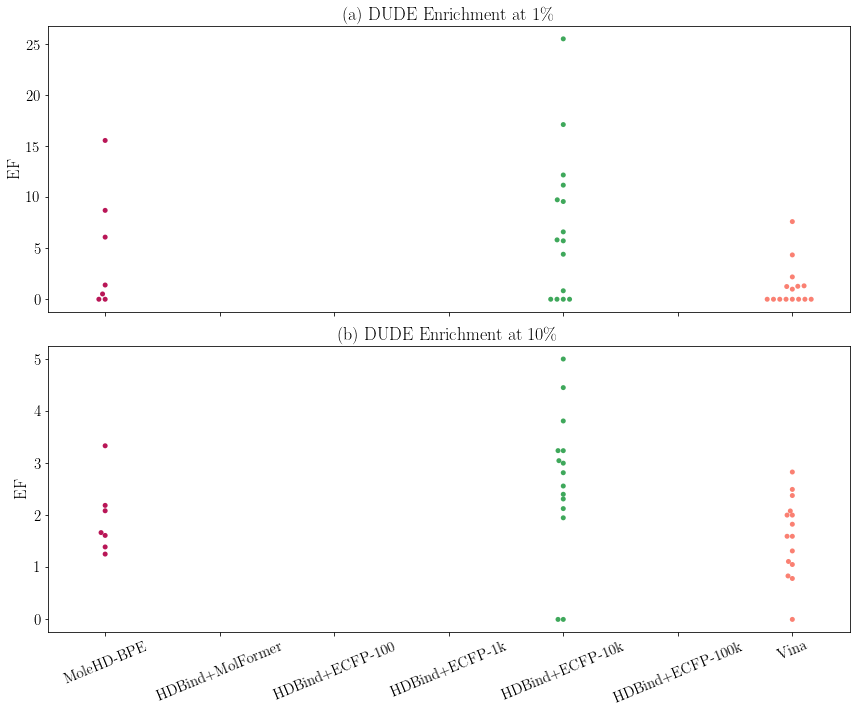

In [83]:
make_box_plot(enrich_1_df=grp_df[grp_df["p"] == .01], 
          enrich_10_df=grp_df[grp_df["p"] == .1],
             dataset="DUDE")

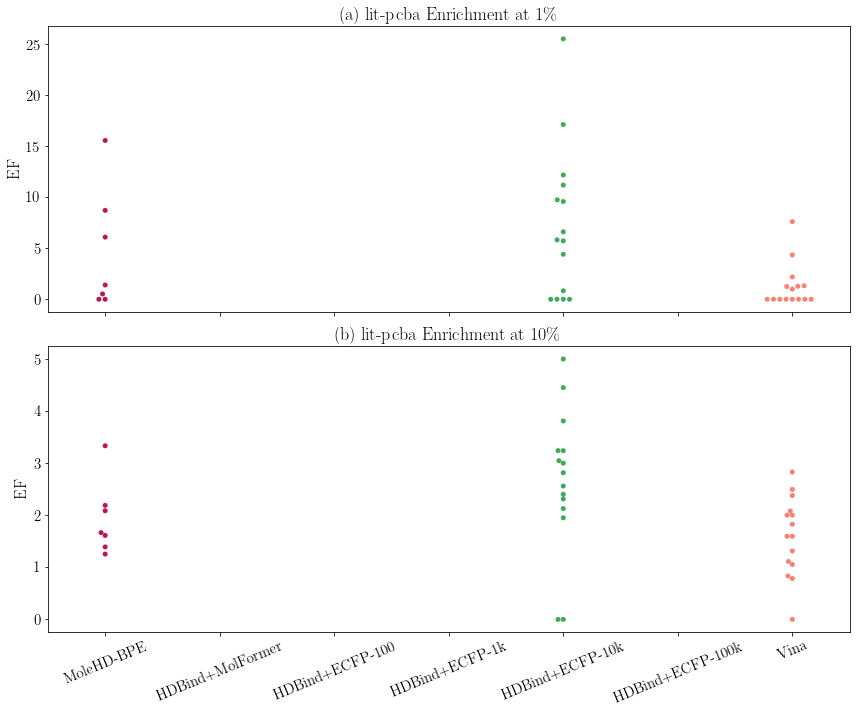

In [84]:
make_box_plot(enrich_1_df=grp_df[grp_df["p"] == .01], 
          enrich_10_df=grp_df[grp_df["p"] == .1],
             dataset="lit-pcba")

- should add the average EF (median?) to the labels on the horizontal axis
- scale the point size by standard deviation?
- standard scale the molformer embeddings?

In [18]:
def timing_plot(input_tup_list:list, dataset:str):
    
    
    f, ax = plt.subplots(1, 1, figsize=(12,10))
    
    df_dict = {"target": [], "model": [], "time": [], "format_name": []}
    for model_name, format_name in input_tup_list:
        
        data_path_list = list(data_p.glob(f"{model_name}.{dataset}*.pkl"))
        
        for path in data_path_list:
            with open(path, "rb") as handle:
                data = pickle.load(handle)
                
                test_time_list = []
                for i in range(10):
                    df_dict["time"].append(data["trials"][i]["test_time"]/data["y_test"].shape[0])
                    df_dict["target"].append(path.name)
                    df_dict["model"].append(model_name)
                    df_dict["format_name"].append(format_name)
                    

    df = pd.DataFrame(df_dict)
    xlabels = (df.groupby(["model", "format_name"]).median().reset_index()["format_name"]).values.tolist()
#     import pdb
#     pdb.set_trace()
    sns.swarmplot(data=df.groupby(["target", "model", "format_name"]).median().reset_index(),
                  order=[x for x in model_dict.keys()],
                  x="model", y="time", ax=ax)

    ax.tick_params(axis="x", labelrotation=22.5)
    ax.set_yscale("log")
#     labels = [item.get_text() for item in ax.get_xticklabels()]
#     labels = [x[1] for x in input_tup_list]
    ax.set_xticklabels(xlabels)
    
    f.savefig("lit-pcba-timing.png", dpi=600, bbox_inches="tight")
    
    return df
    

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

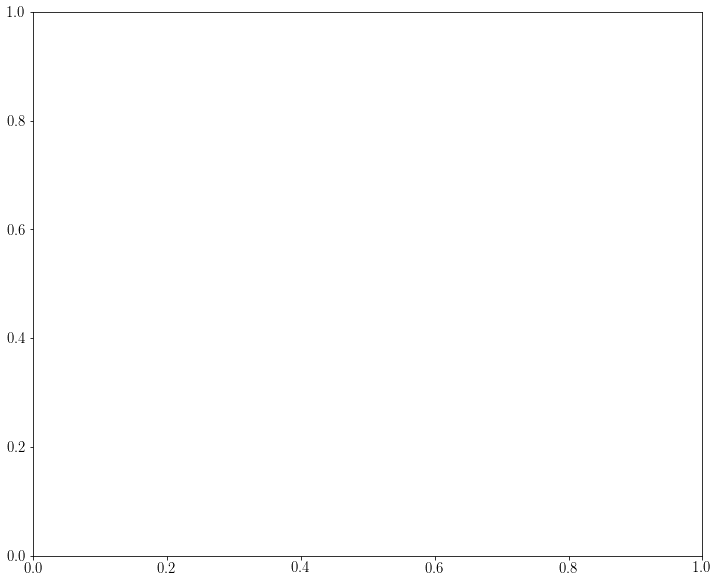

In [19]:
time_df = timing_plot([("mlp-1024-1", "MLP (GPU)"),
            ("hdbind-rp-molformer", "RP-MolFormer (GPU)"),
            ("molehd-bpe", "MoleHD-BPE (CPU)"),
            ("hdbind-ecfp-1024-1-100", "RP-ECFP-100 (GPU)"),
                      ("hdbind-ecfp-1024-1-1k", "RP-ECFP-1k (GPU)"),
                      ("hdbind-ecfp-1024-1-100k", "RP-ECFP-100k (GPU)")], 
                      dataset="lit-pcba")

In [ ]:
avg_times = time_df.groupby(["model"]).mean()["time"].reset_index()
# avg_times.reset_index()

In [ ]:
avg_times["time"][0], avg_times["model"][0]

In [ ]:
avg_times["time"][1], avg_times["model"][1]

In [ ]:
avg_times["time"][2], avg_times["model"][2]

In [ ]:
avg_times["time"][3], avg_times["model"][3]

In [ ]:
avg_times["time"][4], avg_times["model"][4]

In [ ]:
avg_times["time"][5], avg_times["model"][5]

---

In [ ]:
100 * abs( avg_times["time"][0] - avg_times["time"][4])/(avg_times["time"][4])

In [ ]:
avg_times["time"][4] / avg_times["time"][0]

In [ ]:
avg_times["time"][5] / avg_times["time"][0]

In [ ]:
avg_times["time"][0] / avg_times["time"][1]

- theres way more parameters in the hdbind-rp-molformer as compared to the mlp
- (1024 * 10000 = 10.24M parameters)
- (
- can D go higher? a .85x slow down from 100 to 10000 seems pretty small, there also seems to be a considerable increase in accuracy when pushing D higher...